In [1]:
%matplotlib inline
from desc.equilibrium import EquilibriaFamily
from desc.plotting import plot_surfaces, plot_section, plot_2d
from desc.objectives import MagneticWell
from desc.grid import LinearGrid
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

DESC version 0.4.13+566.g8bda1c3.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 9.00 GB available memory


In [2]:
class MagneticWellTester:
    def __init__(
        self,
        name,
        has_stellopt_data=False,
        use_stellopt_rho=False,
        rho=np.linspace(1 / 30, 1, 30),
    ):
        self.name = name
        # collect final equilibrium
        self.eq = EquilibriaFamily.load(
            load_from="./examples/DESC/" + name + "_output.h5"
        )[-1]

        if has_stellopt_data:
            # pull stellopt data from matlab .mat file
            mat = sio.loadmat(name + "_magwell.mat")
            self.stellopt_magwell = mat["magwell"]
            self.stellopt_rho = mat["rho"]
            self.rho = self.stellopt_rho if use_stellopt_rho else rho
        else:
            self.stellopt_magwell = None
            self.rho = rho

        # cached when compute_magwell() is called
        self.v = np.empty(len(self.rho))  # volume(rho)
        self.dv_drho = np.empty(len(self.rho))  # dv/drho(rho)
        self.v_total = np.empty(len(self.rho))  # data["V"](rho)
        self.magwell = np.empty(len(self.rho))  # magnetic well parameter(rho)

    def print_rho1(self):
        # print the results of compute_magwell() for the rho=1 surface
        # the volume enclosed by the rho=1 surface should match data["V"],
        # the entire volume, but it doesn't

        m = MagneticWell(self.eq)  # uses the default grid where rho = 1
        v, dv_drho, v_total, w = m.compute(
            self.eq.R_lmn,
            self.eq.Z_lmn,
            self.eq.L_lmn,
            self.eq.p_l,
            self.eq.i_l,
            self.eq.Psi,
        )
        print(self.name)
        print(self.eq)
        print("volume enclosed by the rho=1 surface: " + str(v))
        print("dv/drho: " + str(dv_drho))
        print('total volume (data["V"]): ' + str(v_total))
        print("well parameter: " + str(w))
        print()

    def compute_magwell(self):
        # compute and cache MagneticWell.compute() values
        # for the given array of rho=constant surfaces

        for i in range(len(self.rho)):
            grid = LinearGrid(
                L=1,
                M=2 * self.eq.M_grid + 10,
                N=2 * self.eq.N_grid + 10,
                NFP=self.eq.NFP,
                sym=self.eq.sym,
                rho=self.rho[i],
            )
            m = MagneticWell(eq=self.eq, grid=grid)
            v, dv_drho, v_total, w = m.compute(
                self.eq.R_lmn,
                self.eq.Z_lmn,
                self.eq.L_lmn,
                self.eq.p_l,
                self.eq.i_l,
                self.eq.Psi,
            )
            self.v[i] = v
            self.dv_drho[i] = dv_drho
            self.v_total[i] = v_total
            self.magwell[i] = w

    def plot(self, width=5, height=5):
        # plot all quantities cached from compute_magwell()
        # and STELLOPT data if it exists

        ncols = 4 if self.stellopt_magwell is None else 5
        fig, ax = plt.subplots(ncols=ncols)
        fig.set_size_inches(ncols * width, height)

        titles = (
            "volume(rho) surface integral computation",
            "dv/drho",
            'data["V"] for linear grids of different rho=constant',
            "DESC: magnetic well parameter",
            "STELLOPT: magnetic well parameter",
        )
        y_values = (
            self.v,
            self.dv_drho,
            self.v_total,
            self.magwell,
            self.stellopt_magwell,
        )
        for i in range(ncols):
            rho = self.rho if i < ncols - 1 else self.stellopt_rho
            ax[i].scatter(rho, y_values[i])
            ax[i].plot(rho, y_values[i])
            ax[i].set_title(self.name + ": " + titles[i])

In [3]:
dshape = MagneticWellTester("DSHAPE", has_stellopt_data=True, use_stellopt_rho=True)
heliotron = MagneticWellTester(
    "HELIOTRON", has_stellopt_data=True, use_stellopt_rho=True
)
axisym = MagneticWellTester("AXISYM", has_stellopt_data=False)

(<Figure size 384x480 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd574c69310>],
       dtype=object))

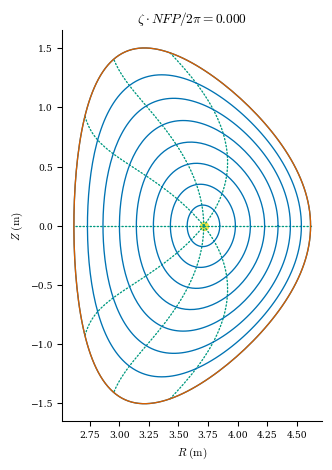

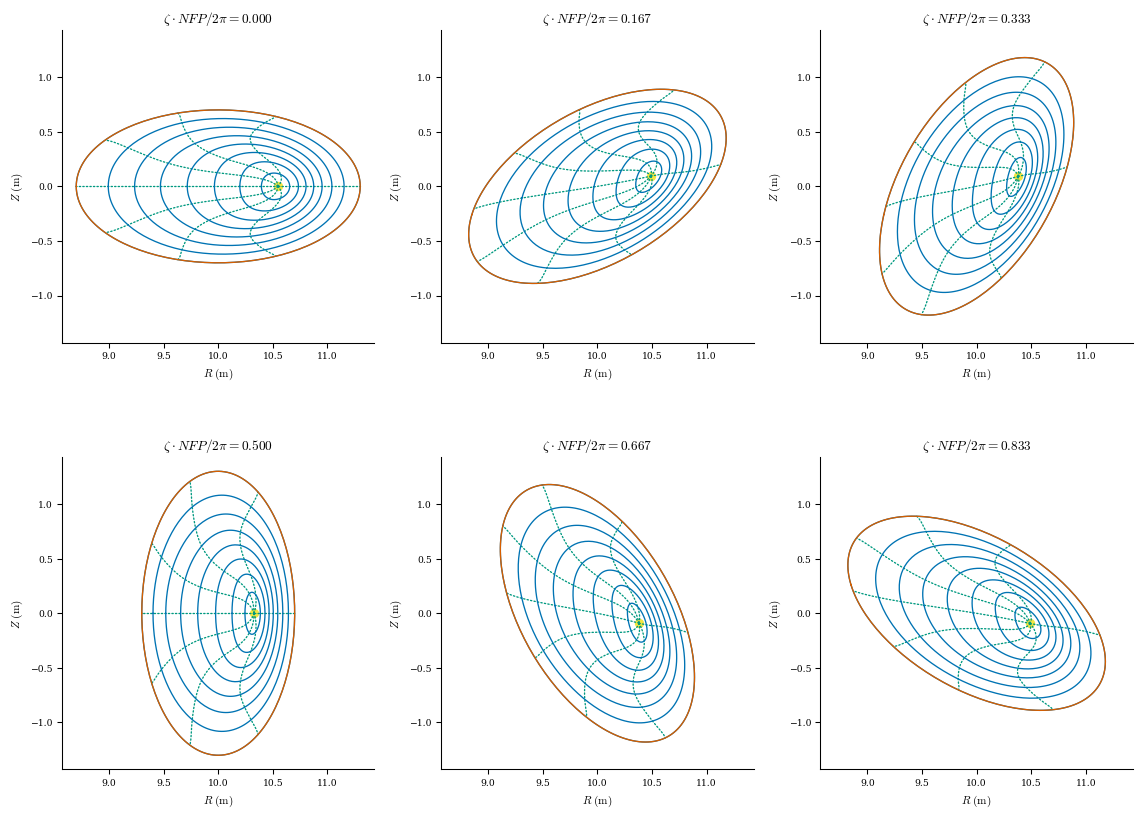

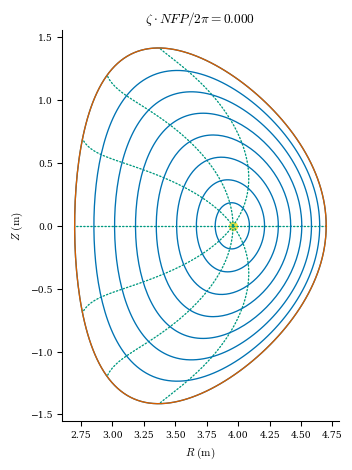

In [4]:
# just to make sure equilibrium were solved correctly on my computer
plot_surfaces(dshape.eq)
plot_surfaces(heliotron.eq)
plot_surfaces(axisym.eq)

In [5]:
dshape.print_rho1()
heliotron.print_rho1()
axisym.print_rho1()

DSHAPE
Equilibrium at 0x7fd5c8109820 (L=26, M=13, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
volume enclosed by the rho=1 surface: 77.2858274674659
dv/drho: 135.23615209008204
total volume (data["V"]): 168.593195468514
well parameter: [0.10346503]

HELIOTRON
Equilibrium at 0x7fd5c80863d0 (L=24, M=12, N=3, NFP=19.0, sym=1, spectral_indexing=fringe)
volume enclosed by the rho=1 surface: 51.71098578880827
dv/drho: 132.7588886471737
total volume (data["V"]): 440.0449133259921
well parameter: [-0.85354713]

AXISYM
Equilibrium at 0x7fd5b8c42fd0 (L=40, M=20, N=0, NFP=1.0, sym=1, spectral_indexing=fringe)
volume enclosed by the rho=1 surface: 77.01038750447835
dv/drho: 123.82553929022993
total volume (data["V"]): 154.87160079803675
well parameter: [-0.13968627]



In [6]:
# generate data for plots
dshape.compute_magwell()
heliotron.compute_magwell()

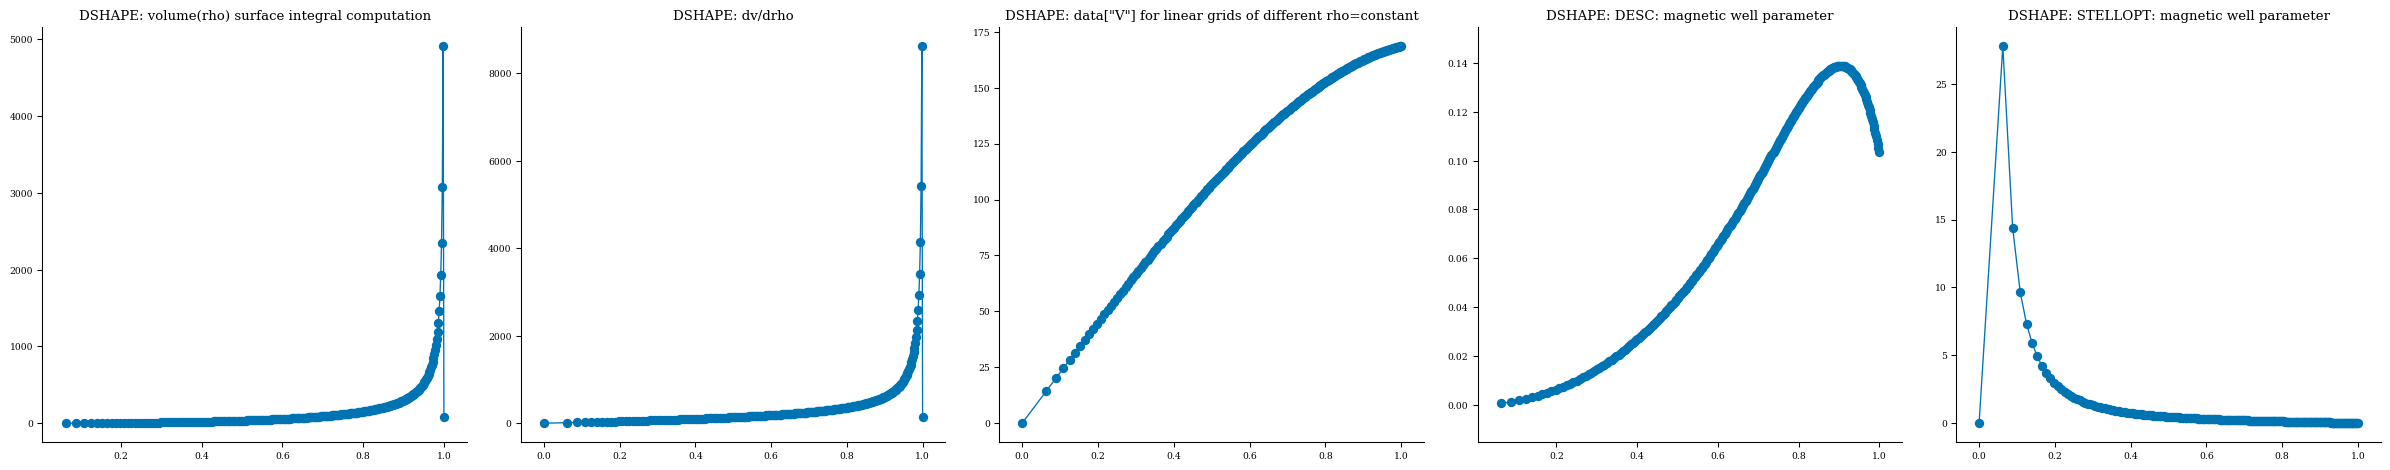

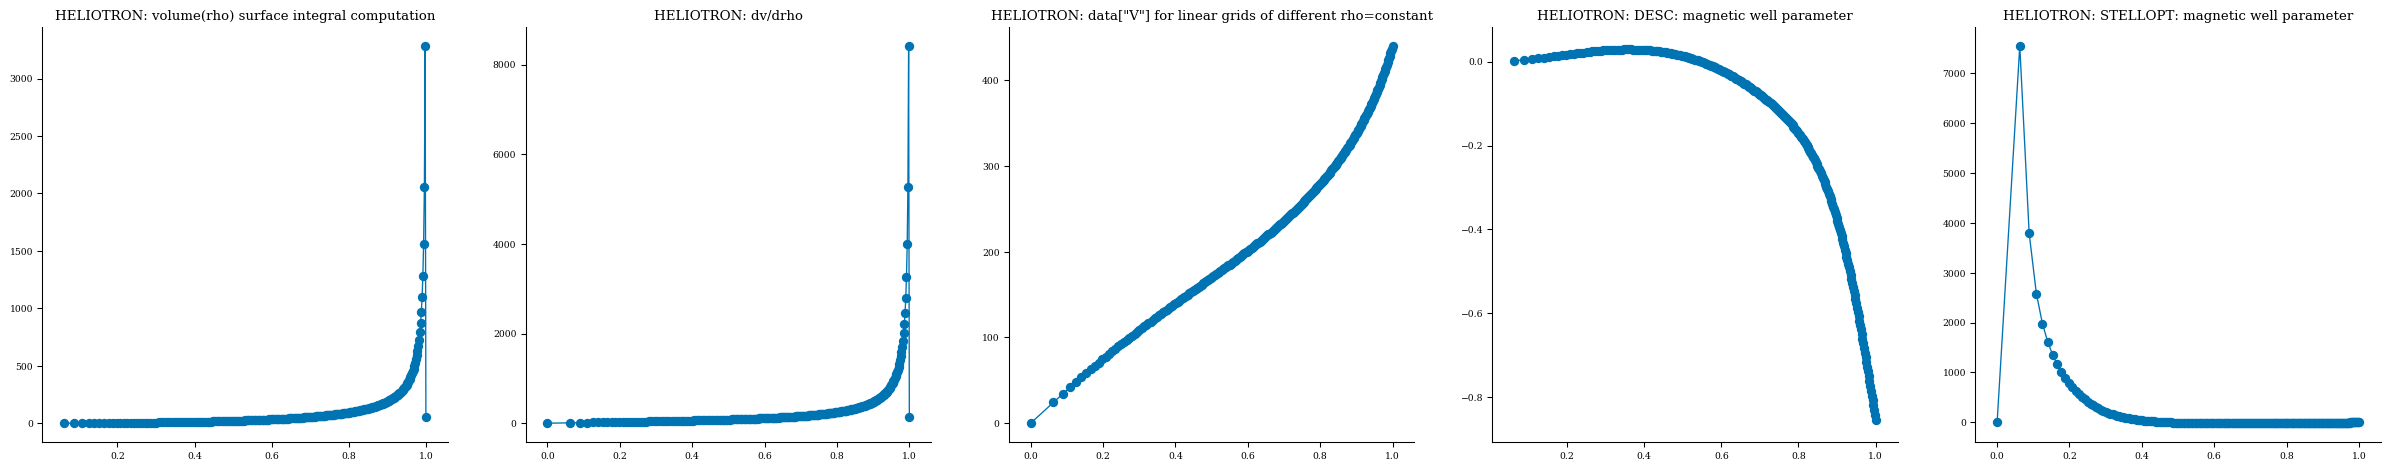

In [7]:
dshape.plot()
heliotron.plot()

![DSHAPE_magwell.png](DSHAPE_magwell.png)

![HELIOTRON_magwell.png](HELIOTRON_magwell.png)

In [8]:
# also what rho=constant surface does MagneticWell return a result for when the rho input for grid is an array?
grid = LinearGrid(
    M=2 * dshape.eq.M_grid + 10,
    N=2 * dshape.eq.N_grid + 10,
    NFP=dshape.eq.NFP,
    sym=dshape.eq.sym,
    rho=np.linspace(1 / 30, 1, 30),
)
MagneticWell(eq=dshape.eq, grid=grid).compute(
    dshape.eq.R_lmn,
    dshape.eq.Z_lmn,
    dshape.eq.L_lmn,
    dshape.eq.p_l,
    dshape.eq.i_l,
    dshape.eq.Psi,
)

(DeviceArray(875.55739993, dtype=float64),
 DeviceArray(2511.66802193, dtype=float64),
 DeviceArray(102.04053197, dtype=float64),
 DeviceArray([0.07487071], dtype=float64))